# Notebook to demonstrate evaluation divergence of video summarization models 

Rough approach: take trained model output, see if trained model output diverges 

# Helper functions and model loading:

In [1]:
import h5py 
import numpy as np 
import json 
from Utils import *
from Model import model_dict,params_dict
import os 
import torch
from Data import VideoData
from torch.utils.data import DataLoader
import torch.optim as optim
from tqdm import tqdm

In [4]:
 # Should do comparisons of any pred with avg/user annotations 
def correlation_single_pred(score,video_name,dataset,dataset_name='tvsum',downsample_gt=True):
    "This compares the scores with a downsampled version of the ground truth"
    kendall_spearman_scores = []
    if dataset_name=="tvsum":
        data = load_tvsum_mat('Utils//ydata-tvsum50.mat')
        video_number = int(video_name.split('_')[1])
        all_user_summary = data[video_number-1]['user_anno'].T
        pick = dataset[video_name]['picks']
        all_correlations_tau = []
        all_correlations_spearman = []
        for user_summary in all_user_summary:
            if downsample_gt:
                down_sampled_summary = (user_summary/user_summary.max())[pick] # Change this to take the picks from which a certain frame was sampled from
            else:
                down_sampled_summary = (user_summary/user_summary.max())
        
            correlation_tau = kendalltau(-rankdata(down_sampled_summary),-rankdata(score))[0]
            correlation_spear = spearmanr(down_sampled_summary,score)[0]
            all_correlations_tau.append(correlation_tau)
            all_correlations_spearman.append(correlation_spear)
        kendall_spearman_scores.append(np.mean(all_correlations_tau))
        kendall_spearman_scores.append(np.mean(all_correlations_spearman))
    elif dataset_name =="summe":
        user_summarie = dataset[video_name]['user_summary']
        pick = dataset[video_name]['picks']
        if downsample_gt:
            averaged_downsampled_summary = np.average(user_summarie,axis=0)[::15]
        else:
            averaged_downsampled_summary = np.average(user_summarie,axis=0)
        kendall_score = kendalltau(rankdata(averaged_downsampled_summary),rankdata(score))[0]
        spearman_score = spearmanr(averaged_downsampled_summary,score)[0]
        kendall_spearman_scores.append(np.mean(kendall_score))
        kendall_spearman_scores.append(np.mean(spearman_score))
    
    return kendall_spearman_scores

# This should take an Upsampled score, or post knapsack score and then compare the correlation between them
def correlation_with_knapsack_scores(score,video_name,dataset):
    kendall_spearman_scores = []
    avg_correlation_kendall = []
    avg_correlation_spearman = []
    user_summaries = dataset[video_name]['user_summary'][...]
    for user_summary in user_summaries:
        avg_correlation_kendall.append(kendalltau(-rankdata(user_summary),-rankdata(score))[0])
        avg_correlation_spearman.append(spearmanr(user_summary,score)[0])
    kendall_spearman_scores.append(np.mean(avg_correlation_kendall))
    kendall_spearman_scores.append(np.mean(avg_correlation_spearman))

    return kendall_spearman_scores

def correlation_with_average_gt(score,video_name,dataset):
    kendall_spearman_scores = []
    user_summary = dataset[video_name]['gtscore'][...]
    kendall_spearman_scores.append(kendalltau(-rankdata(user_summary),-rankdata(score))[0])
    kendall_spearman_scores.append(spearmanr(user_summary,score)[0])

    return kendall_spearman_scores


def upsample_prediction(score,picks,video_length):
    upsampled_pred = np.zeros(video_length)
    for i in range(len(picks)-1):
        upsampled_pred[picks[i]:picks[i+1]] = score[i]

    return upsampled_pred 
def knapsack_wrapper_with_rating(score,test_index,dataset,dataset_name):
    shot_boundaries = dataset[test_index]['change_points'][...]
    positions = dataset[test_index]['picks'][...]
    n_frames = dataset[test_index]['n_frames'][...]
    knapsack_pred = generate_summary_single(shot_boundaries,score,n_frames,positions)
    return correlation_single_pred(knapsack_pred,test_index,dataset,dataset_name,False)

def knapsack_wrapper_with_post_process(score,test_index,dataset,dataset_name):
    shot_boundaries = dataset[test_index]['change_points'][...]
    positions = dataset[test_index]['picks'][...]
    n_frames = dataset[test_index]['n_frames'][...]
    knapsack_pred = generate_summary_single(shot_boundaries,score,n_frames,positions)
    return correlation_with_knapsack_scores(knapsack_pred,test_index,dataset)


def upsample_wrapper(score,test_index,dataset,dataset_name):
    positions = dataset[test_index]['picks'][...]
    n_frames = dataset[test_index]['n_frames'][...]
    upsampled_pred = upsample_prediction(score,positions,n_frames)
    return correlation_single_pred(upsampled_pred,test_index,dataset,dataset_name,False)



In [5]:
def train(config_path,save_path = 'weights'):
    with open(config_path,'r') as config_file:
        config = json.load(config_file)
    
    assert config['Model'] in model_dict.keys(), "Model is not available, modify dictionary to include them or check spelling"
    dataset_name = config['split'].split("_")[0]
    split_string = config['split'].strip(dataset_name).strip('.json')
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    modelclass = model_dict[config['Model']]
    criterion = loss_dict[config['loss_function']]()
    num_epochs = config["num_epochs"]
    feature_extractor = config['feature_extractor']
    save_name = f'{feature_extractor}_{dataset_name}{split_string}'
    if not os.path.exists(os.path.join(save_path,save_name,dataset_name,config['Model'] )):
        os.makedirs(os.path.join(save_path,save_name,dataset_name,config['Model'] ))


    save_path = os.path.join(save_path,save_name,dataset_name,config['Model'])


    params = params_dict[config['Model']][config['feature_extractor']]

    if config['data_aug'] :
        #data_augmentations  = [shuffle_dict[data_aug](**config['data_aug'][data_aug]) for data_aug in config['data_aug']]
        pass
    else:
        data_augmentations = []
    splits = config['total_splits'] if 'total_splits' in config.keys() else 5
    #dataset = h5py.File(config['datapath']+'.h5')
    dataset = h5py.File(os.path.join('Data',config['feature_extractor'],f'{config["feature_extractor"]}_{dataset_name}.h5'))
    print(params)
    split_perfs_1 = []
    split_perfs_2 = []
    split_perfs_3 = []
    split_perfs_4 = []
    split_perfs_5 = []
    for split in range(splits):
        print(f"Running Split:  {split+1}  for model: {config['Model']}")
        model = modelclass(**params)
        batchloader = VideoData('train',config['split'],split,transforms=data_augmentations,feature_extractor=feature_extractor,trainval=True)
        batchloader = DataLoader(batchloader,batch_size=1,shuffle=True)
        testdata = VideoData('test',config['split'],split,feature_extractor=feature_extractor,trainval=True)
        testloader = DataLoader(testdata,batch_size=1,shuffle=False)
        optimizer = optim.Adam(model.parameters(), lr=config["learning_rate"],weight_decay=config['reg'])
        best_f1_score = -float('inf')
        best_correlation = -float('inf')
        best_correlation_scenario_2 = -float('inf')
        best_correlation_scenario_3 = -float('inf')
        best_correlation_scenario_4 = -float('inf')
        best_correlation_scenario_5 = -float('inf')
        model.to(device)
        if 'gradnorm_clip' in config:
            gradnorm_clip = config['gradnorm_clip']
        else:
            gradnorm_clip = 2
        # Make the directory for the split if it doesn't exist 
        if not os.path.exists(os.path.join(save_path,f'split_{split+1}')):
            os.mkdir(os.path.join(save_path,f'split_{split+1}'))
        save_path_split = os.path.join(save_path,f'split_{split+1}')
        for epoch in range(50):
            model.train()
            running_loss = 0.0
            total_samples = 0

            for data in tqdm(batchloader, desc=f"Epoch {epoch+1}/{num_epochs}", ncols=100):
                inputs, labels = data[0].to(device), data[1].to(device)
                optimizer.zero_grad()
                labels-=labels.min()
                labels/=labels.max()
                outputs = model(inputs)
                if len(outputs.shape)>2:
                    outputs = outputs.squeeze(-1)
                loss = criterion(outputs, labels)
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), gradnorm_clip)
                optimizer.step()
                running_loss += loss.item()
                total_samples+=1
            epoch_loss = running_loss / len(batchloader)

            model.eval()
            test_datapoints = []
            test_names = []
            
# Adding the correlation scores to have the picks from the datapoints 
            print(f"Compute F1 and Correlation for epoch: {epoch+1}")
            for inputs_t,names in tqdm(testloader,ncols=len(testdata)):
                with torch.no_grad():
                    importance_scores = model(inputs_t.to(device))
                importance_scores = importance_scores[0].to('cpu').tolist()
                test_datapoints.append(importance_scores)
                test_names.append(names[0])
            all_scores = eval_summary(test_datapoints,dataset,test_names,dataset_name)

            #TODO: At this point add the scenario scorring, basically do each operation to add to the scenario list 


            correlation_dict = evaluate_correlation(test_datapoints ,dataset,test_names,dataset_name)
            scenario_2 = [knapsack_wrapper_with_rating(score,test_name,dataset,dataset_name) for score,test_name in zip(test_datapoints,test_names)]
            scenario_3 = [knapsack_wrapper_with_post_process(score,test_name,dataset,dataset_name) for score,test_name in zip(test_datapoints,test_names)]
            scenario_4 = [upsample_wrapper(score,test_name,dataset,dataset_name) for score,test_name in zip(test_datapoints,test_names)] # Eaach of these is one 
            scenario_5 = [correlation_with_average_gt(score,test_name,dataset) for score,test_name in zip(test_datapoints,test_names)] 
            if correlation_dict['Average_Kendall']> best_correlation:    
                print(f"Saving epoch {epoch+1}")
                best_correlation = correlation_dict['Average_Kendall']
                #torch.save(model.state_dict(), os.path.join(save_path_split,"best_run_corr" + ".pth")) 
            if np.mean(np.array(scenario_2)[:,0]) > best_correlation_scenario_2:
                best_correlation_scenario_2  = np.mean(np.array(scenario_2)[:,0])
            if np.mean(np.array(scenario_3)[:,0]) > best_correlation_scenario_3:
                best_correlation_scenario_3  = np.mean(np.array(scenario_3)[:,0])
            if np.mean(np.array(scenario_4)[:,0]) > best_correlation_scenario_4:
                best_correlation_scenario_4  = np.mean(np.array(scenario_4)[:,0])
            if np.mean(np.array(scenario_5)[:,0]) > best_correlation_scenario_5:
                best_correlation_scenario_5  = np.mean(np.array(scenario_5)[:,0])
            
            
            if np.mean(all_scores).item() > best_f1_score:
                best_f1_score = np.mean(all_scores).item()
                print(f"Best F1 Score:  {epoch+1}: {best_f1_score} ")
                #torch.save(model.state_dict(), os.path.join(save_path_split,"best_run_f1" + ".pth"))

        print(f'Best F1 score for split {split+1}: {best_f1_score} ')
        print(f'Best Correlation for split {split+1}: {best_correlation} ')
        print(f'Best Correlation of split {split+1}for Scenario 2: {best_correlation_scenario_2} ')
        print(f'Best Correlation of split {split+1}for Scenario 3: {best_correlation_scenario_3} ')
        print(f'Best Correlation of split {split+1}for Scenario 4: {best_correlation_scenario_4} ')
        split_perfs_1.append(best_correlation)
        split_perfs_2.append(best_correlation_scenario_2)
        split_perfs_3.append(best_correlation_scenario_3)
        split_perfs_4.append(best_correlation_scenario_4)
        split_perfs_5.append(best_correlation_scenario_5)

    print('Completed Training')
    return np.mean(split_perfs_1),np.mean(split_perfs_2),np.mean(split_perfs_3),np.mean(split_perfs_4),np.mean(split_perfs_5)

In [ ]:
ten_trial_scenario_1 = []
ten_trial_scenario_2 = []
ten_trial_scenario_3 = []
ten_trial_scenario_4 = []
ten_trial_scenario_5 = []
for i in range(5):
    best_correlation,best_correlation_scenario_2,best_correlation_scenario_3,best_correlation_scenario_4,best_correlation_scenario_5  = train('Configs/LSTM/resnet_tvsum_can_1.json')
    ten_trial_scenario_1.append(best_correlation)
    ten_trial_scenario_2.append(best_correlation_scenario_2)
    ten_trial_scenario_3.append(best_correlation_scenario_3)
    ten_trial_scenario_4.append(best_correlation_scenario_4)
    ten_trial_scenario_5.append(best_correlation_scenario_5)

In [7]:
print(np.mean(ten_trial_scenario_1))
print(np.mean(ten_trial_scenario_2))
print(np.mean(ten_trial_scenario_3))
print(np.mean(ten_trial_scenario_4))
print(np.mean(ten_trial_scenario_5))

0.17770541498528364
0.1159564515666821
0.5142722878358239
0.18433339678359412
0.3155558876638479


In [8]:
len(ten_trial_scenario_1)

5

In [9]:
print(np.var(ten_trial_scenario_1))
print(np.var(ten_trial_scenario_2))
print(np.var(ten_trial_scenario_3))
print(np.var(ten_trial_scenario_4))
print(np.var(ten_trial_scenario_5))

3.5206572776631505e-06
7.772500740938329e-07
3.0345162031782436e-06
2.933383406825805e-06
1.8164328216496344e-05


In [ ]:
ten_trial_scenario_1 = []
ten_trial_scenario_2 = []
ten_trial_scenario_3 = []
ten_trial_scenario_4 = []
ten_trial_scenario_5 = []
for i in range(5):
    best_correlation,best_correlation_scenario_2,best_correlation_scenario_3,best_correlation_scenario_4,best_correlation_scenario_5  = train('Configs/LSTM/resnet_summe_can_1.json')
    ten_trial_scenario_1.append(best_correlation)
    ten_trial_scenario_2.append(best_correlation_scenario_2)
    ten_trial_scenario_3.append(best_correlation_scenario_3)
    ten_trial_scenario_4.append(best_correlation_scenario_4)
    ten_trial_scenario_5.append(best_correlation_scenario_5)

In [12]:
print(np.mean(ten_trial_scenario_1))
print(np.mean(ten_trial_scenario_2))
print(np.mean(ten_trial_scenario_3))
print(np.mean(ten_trial_scenario_4))
print(np.mean(ten_trial_scenario_5))

0.07220610168079519
0.17429175337627223
0.1063390633150213
0.07808752350819474
0.07220610168079519


In [ ]:
print(np.var(ten_trial_scenario_1))
print(np.var(ten_trial_scenario_2))
print(np.var(ten_trial_scenario_3))
print(np.var(ten_trial_scenario_4))
print(np.var(ten_trial_scenario_5))

In [ ]:
ten_trial_scenario_1 = []
ten_trial_scenario_2 = []
ten_trial_scenario_3 = []
ten_trial_scenario_4 = []
ten_trial_scenario_5 = []
for i in range(10):
    best_correlation,best_correlation_scenario_2,best_correlation_scenario_3,best_correlation_scenario_4,best_correlation_scenario_5  = train('Configs/LSTM/resnet_summe_can_1.json')
    ten_trial_scenario_1.append(best_correlation)
    ten_trial_scenario_2.append(best_correlation_scenario_2)
    ten_trial_scenario_3.append(best_correlation_scenario_3)
    ten_trial_scenario_4.append(best_correlation_scenario_4)
    ten_trial_scenario_5.append(best_correlation_scenario_5)

Testing before main experiment      

In [39]:
split_level_scenario_1 = []
split_level_scenario_2 = []
split_level_scenario_3 = []
split_level_scenario_4 = []
dataset = h5py.File('Data/original/googlenet_tvsum.h5')
test_split = json.load(open('Splits/tvsum_can_1.json'))
model_outputs = json.load(open('SensitivityExpt/tvsum/outputs.json'))
for i in range(5):

    test_split_index = test_split[i]['test_keys']
    scenario_1 = []
    scenario_2 = []
    scenario_3 = []
    scenario_4 = []
    for test_ind in test_split_index:
        test_index = test_ind.split('/')[1]
        shot_boundaries = dataset[test_index]['change_points'][...]
        scores = model_outputs[test_index] 
        positions = dataset[test_index]['picks'][...]
        n_frames = dataset[test_index]['n_frames'][...]
        user_summaries = dataset[test_index]['user_summary'][...]
        post_knapsack_pred = generate_summary_single(shot_boundaries,scores,n_frames,positions)
        upsampled_pred = upsample_prediction(scores,positions,n_frames)
        correlation_scores = correlation_single_pred(scores,test_index,dataset,'tvsum')
        scenario_1.append(correlation_scores)
        correlation_scores = correlation_single_pred(post_knapsack_pred,test_index,dataset,'tvsum',False)
        scenario_2.append(correlation_scores)
        correlation_scores = correlation_with_knapsack_scores(post_knapsack_pred,test_index,dataset)
        scenario_3.append(correlation_scores)
        correlation_scores = correlation_with_knapsack_scores(upsampled_pred,test_index,dataset)
        scenario_4.append(correlation_scores)
    split_level_scenario_1.append(np.mean(np.array(scenario_1)[:,0]))
    split_level_scenario_2.append(np.mean(np.array(scenario_2)[:,0]))
    split_level_scenario_3.append(np.mean(np.array(scenario_3)[:,0]))
    split_level_scenario_4.append(np.mean(np.array(scenario_4)[:,0]))

In [40]:
print('Tvsum scenario performances')
print(f'Scenario 1: {np.mean(split_level_scenario_1)}')
print(f'Scenario 2: {np.mean(split_level_scenario_2)}')
print(f'Scenario 3: {np.mean(split_level_scenario_3)}')
print(f'Scenario 4: {np.mean(split_level_scenario_4)}')

Tvsum scenario performances
Scenario 1: 0.14835575709395488
Scenario 2: 0.09762647121752868
Scenario 3: 0.448509825824967
Scenario 4: 0.09768388242721733


In [52]:
# Note: SumMe's results are taken from the best f1 score to simulate the scenario better
split_level_scenario_1 = []
split_level_scenario_2 = []
split_level_scenario_3 = []
split_level_scenario_4 = []
dataset = h5py.File('Data/original/googlenet_summe.h5')
test_split = json.load(open('Splits/summe_can_1.json'))
model_outputs = json.load(open('SensitivityExpt/summe/outputs.json'))
for i in range(5):

    test_split_index = test_split[i]['test_keys']
    scenario_1 = []
    scenario_2 = []
    scenario_3 = []
    scenario_4 = []
    for test_ind in test_split_index:
        test_index = test_ind.split('/')[1]
        shot_boundaries = dataset[test_index]['change_points'][...]
        scores = model_outputs[test_index] 
        positions = dataset[test_index]['picks'][...]
        n_frames = dataset[test_index]['n_frames'][...]
        user_summaries = dataset[test_index]['user_summary'][...]
        post_knapsack_pred = generate_summary_single(shot_boundaries,scores,n_frames,positions)
        upsampled_pred = upsample_prediction(scores,positions,n_frames)
        correlation_scores = correlation_single_pred(scores,test_index,dataset,'summe')
        scenario_1.append(correlation_scores)
        correlation_scores = correlation_single_pred(post_knapsack_pred,test_index,dataset,'summe',False)
        scenario_2.append(correlation_scores)
        correlation_scores = correlation_with_knapsack_scores(post_knapsack_pred,test_index,dataset)
        scenario_3.append(correlation_scores)
        correlation_scores = correlation_with_knapsack_scores(upsampled_pred,test_index,dataset)
        scenario_4.append(correlation_scores)
    split_level_scenario_1.append(np.mean(np.array(scenario_1)[:,0]))
    split_level_scenario_2.append(np.mean(np.array(scenario_2)[:,0]))
    split_level_scenario_3.append(np.mean(np.array(scenario_3)[:,0]))
    split_level_scenario_4.append(np.mean(np.array(scenario_4)[:,0]))

In [54]:
print('SumMe scenario performances')
print(f'Scenario 1: {np.mean(split_level_scenario_1)}')
print(f'Scenario 2: {np.mean(split_level_scenario_2)}')
print(f'Scenario 3: {np.mean(split_level_scenario_3)}')
print(f'Scenario 4: {np.mean(split_level_scenario_4)}')

SumMe scenario performances
Scenario 1: 0.01714054856509108
Scenario 2: 0.11614957618222801
Scenario 3: 0.07106050549293787
Scenario 4: 0.0046129539971289735


In [50]:
dataset = h5py.File('Data/original/googlenet_tvsum.h5')
test_split = json.load(open('Splits/tvsum_can_1.json'))
test_split_index = test_split[0]['test_keys']
test_index = 'video_6'
model_outputs = json.load(open('SensitivityExpt/Attention/Output/outputs.json'))
user_summaries = dataset[test_index]['user_summary'][...]
shot_boundaries = dataset[test_index]['change_points'][...]
scores = model_outputs[test_index] 
positions = dataset[test_index]['picks'][...]
n_frames = dataset[test_index]['n_frames'][...]
post_knapsack_pred = generate_summary_single(shot_boundaries,scores,n_frames,positions)
upsampled_pred = upsample_prediction(scores,positions,n_frames)


In [21]:
import matplotlib.pyplot as plt

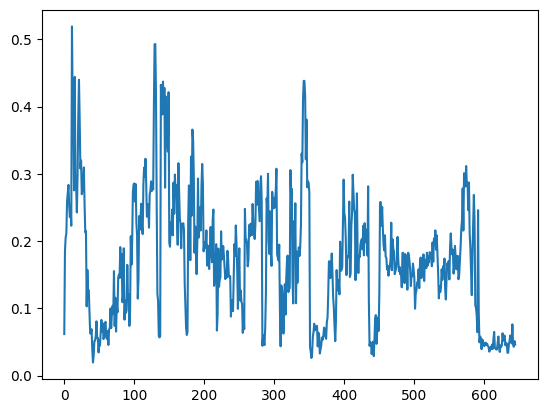

In [48]:
plt.plot(scores)

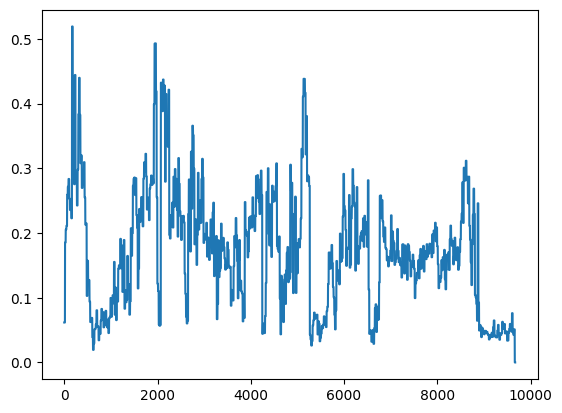

In [49]:
plt.plot(upsampled_pred)

In [ ]:
dataset[test_index]['picks'][...]

In [52]:
dataset = h5py.File('Data/original/googlenet_tvsum.h5')
test_split = json.load(open('Splits/tvsum_can_1.json'))
test_split_index = test_split[0]['test_keys']

model_outputs = json.load(open('SensitivityExpt/Attention/Output/outputs.json'))
scenario_1 =[]
scenario_2 = []
scenario_3 = []
scenario_4  = []
for test_ind in test_split_index:
    test_index = test_ind.split('/')[1]
    shot_boundaries = dataset[test_index]['change_points'][...]
    scores = model_outputs[test_index] 
    positions = dataset[test_index]['picks'][...]
    n_frames = dataset[test_index]['n_frames'][...]
    user_summaries = dataset[test_index]['user_summary'][...]
    post_knapsack_pred = generate_summary_single(shot_boundaries,scores,n_frames,positions)
    upsampled_pred = upsample_prediction(scores,positions,n_frames)
    print('Evaluating Correlation with Downsampled prediction and 0 to 1 scores')
    correlation_scores = correlation_single_pred(scores,test_index,dataset,'tvsum')
    print(f'Kendall scores:  {correlation_scores[0]}')
    scenario_1.append(correlation_scores)
    print('Evaluating scores with Post knapsack Processing and 0 to 1 scores')
    correlation_scores = correlation_single_pred(post_knapsack_pred,test_index,dataset,'tvsum',False)
    print(f'Kendall scores:  {correlation_scores[0]}')
    scenario_2.append(correlation_scores)
    print('Evaluating upsampled predictions with 0/1 selection annotations')
    correlation_scores = correlation_with_knapsack_scores(post_knapsack_pred,test_index,dataset)
    print(f'Kendall scores:  {correlation_scores[0]}')
    scenario_3.append(correlation_scores)
    print('Evaluating scores with Post knapsack Processing  with 0/1 selection annotations ')
    correlation_scores = correlation_with_knapsack_scores(upsampled_pred,test_index,dataset)
    print(f'Kendall scores:  {correlation_scores[0]}')
    scenario_4.append(correlation_scores)
    

    # Comparing correlation between the scores and the predictions directly 

    

Evaluating Correlation with Downsampled prediction and 0 to 1 scores
Kendall scores:  0.25025294614714755
Evaluating scores with Post knapsack Processing and 0 to 1 scores
Kendall scores:  0.15057929969664877
Evaluating upsampled predictions with 0/1 selection annotations
Kendall scores:  0.5810825475029358
Evaluating scores with Post knapsack Processing  with 0/1 selection annotations 
Kendall scores:  0.11422450160324012
Evaluating Correlation with Downsampled prediction and 0 to 1 scores
Kendall scores:  0.25172516396331124
Evaluating scores with Post knapsack Processing and 0 to 1 scores
Kendall scores:  0.2437371200199751
Evaluating upsampled predictions with 0/1 selection annotations
Kendall scores:  0.5105127071920069
Evaluating scores with Post knapsack Processing  with 0/1 selection annotations 
Kendall scores:  0.20476500126322056
Evaluating Correlation with Downsampled prediction and 0 to 1 scores
Kendall scores:  0.21981649518605623
Evaluating scores with Post knapsack Proc

In [53]:
np.array(scenario_1).shape

(10, 2)

In [54]:
print(f'Scenario 1 scores : {np.mean(np.array(scenario_1)[:,0])}')


Scenario 1 scores : 0.14326497464434101


In [55]:
print(f'Scenario 1 scores : {np.mean(scenario_1)}')
print(f'Scenario 2 scores : {np.mean(scenario_2)}')
print(f'Scenario 3 scores : {np.mean(scenario_3)}')
print(f'Scenario 4 scores : {np.mean(scenario_4)}')


Scenario 1 scores : 0.1656474730197641
Scenario 2 scores : 0.09043783376504279
Scenario 3 scores : 0.4719379062384538
Scenario 4 scores : 0.08857751469513639


Training example of different scenario performance